In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)  # 2 for mean and variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        recon = torch.tanh(recon) * 10  # scale output to range -10 to 10
        return recon, mu, logvar

        
# Leer datos
expression_data = pd.read_csv('expr.csv')
methylation_data = pd.read_csv('methyl.csv')
assign_data = pd.read_csv('assign.csv')

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expression_data.fillna(0, inplace=True)
methylation_data.fillna(0, inplace=True)
assign_data.fillna(0, inplace=True)

expression_data = expression_data.values
methylation_data = methylation_data.values
assign_data=assign_data.values
# Asegurar que tienes el mismo número de muestras en ambos conjuntos de datos


assert expression_data.shape[0] == methylation_data.shape[0], "Los datos de expresión y metilación deben tener el mismo número de muestras."
assert assign_data.shape[0] == methylation_data.shape[0], "Los datos de asignación y metilación deben tener el mismo número de muestras."

# Concatenar los datos
#combined_data =torch.FloatTensor(np.hstack((expression_data, methylation_data,assign_data)))
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"
expression_data = torch.FloatTensor(expression_data).to(device)
methylation_data = torch.FloatTensor(methylation_data).to(device)
assign_data = torch.FloatTensor(assign_data).to(device)
combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)

True


In [2]:





# Modelos y optimizadores
vae = VAE(combined_data.shape[1], 256, 100000).to(device)
print(f'El modelo VAE tiene {count_parameters(vae)} parámetros entrenables.')
vae_optimizer = optim.Adam(vae.parameters(), lr=0.0002)

# Función de pérdida para VAE
def loss_vae(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Entrenamiento
n_samples = combined_data.size(0)
batch_size = 64
n_epochs = 10000
start_time = time.time()
for epoch in range(n_epochs):
    for idx in range(0, n_samples, batch_size):
        real_data = combined_data[idx:idx+batch_size].to(device)

        vae_optimizer.zero_grad()
        
        recon_data, mu, logvar = vae(real_data)
        loss = loss_vae(recon_data, real_data, mu, logvar)
        loss.backward()
        vae_optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Loss: {loss.item()}")
        end_time = time.time()

        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()

torch.save(vae.state_dict(), 'vae_model.pth')




El modelo VAE tiene 77256499 parámetros entrenables.
Epoch 100/10000 | Loss: 9922.8017578125
El código tardó 19.76331 segundos en ejecutarse.
Epoch 200/10000 | Loss: 8459.10546875
El código tardó 20.65464 segundos en ejecutarse.
Epoch 300/10000 | Loss: 8143.4853515625
El código tardó 25.54604 segundos en ejecutarse.
Epoch 400/10000 | Loss: 7811.42431640625
El código tardó 25.14094 segundos en ejecutarse.
Epoch 500/10000 | Loss: 7581.330078125
El código tardó 19.82744 segundos en ejecutarse.
Epoch 600/10000 | Loss: 7077.01611328125
El código tardó 19.81658 segundos en ejecutarse.
Epoch 700/10000 | Loss: 6646.12255859375
El código tardó 19.82875 segundos en ejecutarse.
Epoch 800/10000 | Loss: 6400.00341796875
El código tardó 19.86569 segundos en ejecutarse.
Epoch 900/10000 | Loss: 6189.91357421875
El código tardó 21.74251 segundos en ejecutarse.
Epoch 1000/10000 | Loss: 5711.40625
El código tardó 38.64643 segundos en ejecutarse.
Epoch 1100/10000 | Loss: 5698.75390625
El código tardó 38.7

              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         1
          -1       0.93      0.81      0.87       118
           0       0.99      1.00      1.00      2881

    accuracy                           0.99      3000
   macro avg       0.64      0.60      0.62      3000
weighted avg       0.99      0.99      0.99      3000



/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fede/PyEnv/PB/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


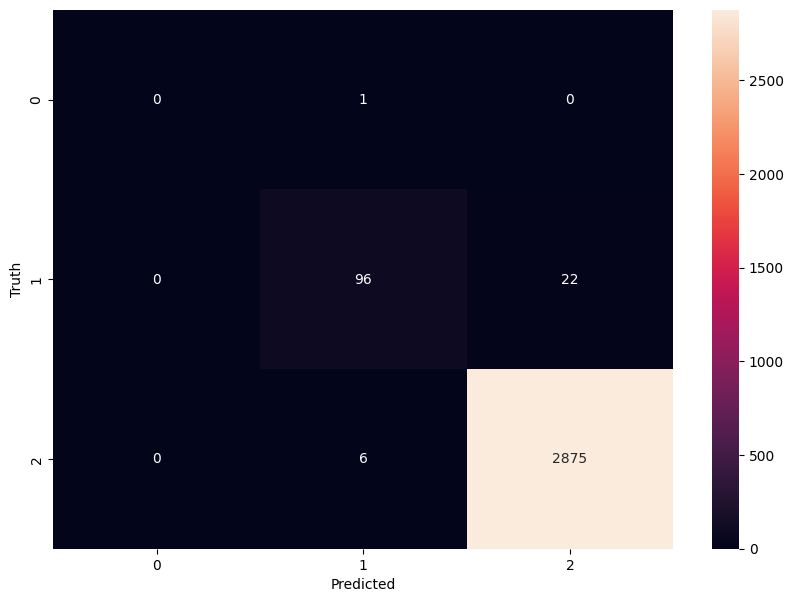

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

vae = VAE(combined_data.shape[1], 256, 100000).to(device)
vae.load_state_dict(torch.load('vae_model.pth'))
vae.eval()

# Función para reparametrización (para generar muestras del espacio latente)

# Generar datos de expresión sintética
expressions_list = []
for i in range(10000):
    with torch.no_grad():
        # Puedes elegir mu y logvar como quieras, pero una opción común es usar 0 y 1
        mu = torch.zeros(1, 100000).to(device)
        logvar = torch.ones(1, 100000).to(device)
        
        z = vae.reparameterize(mu, logvar).to(device)
        synthetic_expression = vae.decoder(z).to(device)
        #print(synthetic_expression)
        expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X = pd.DataFrame(expressions_list)
#X = X.apply(pd.to_numeric, errors='coerce')
y = X.iloc[:, -1].values.astype(int)  # Suponiendo que la asignación está en la primera columna

X = X.iloc[:, :-1]
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2370
           2       1.00      1.00      1.00       630

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



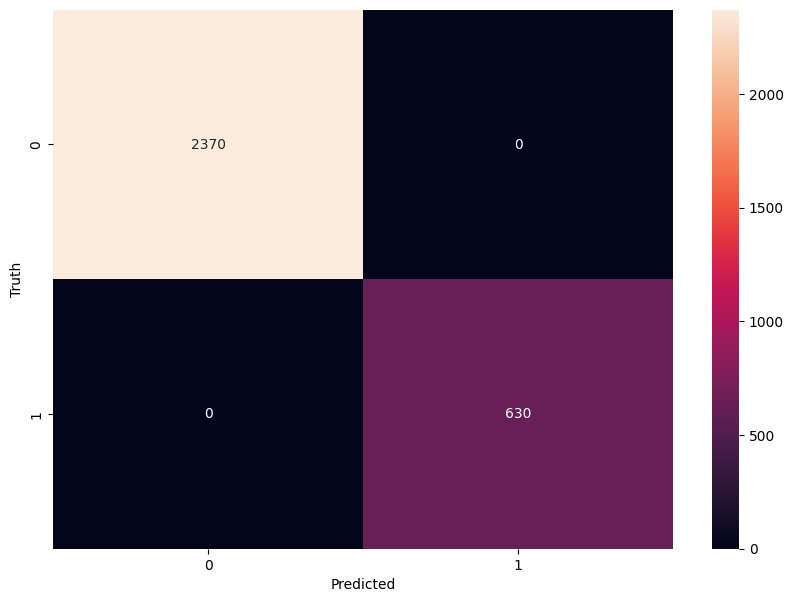

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprLOW.csv')
meth_data = pd.read_csv('methylLOW.csv')
assig_data = pd.read_csv('assignLOW.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = pd.concat([expr_data, meth_data], axis=1)
y = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


              precision    recall  f1-score   support

           1       1.00      1.00      1.00     23934
           2       1.00      1.00      1.00      6066

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



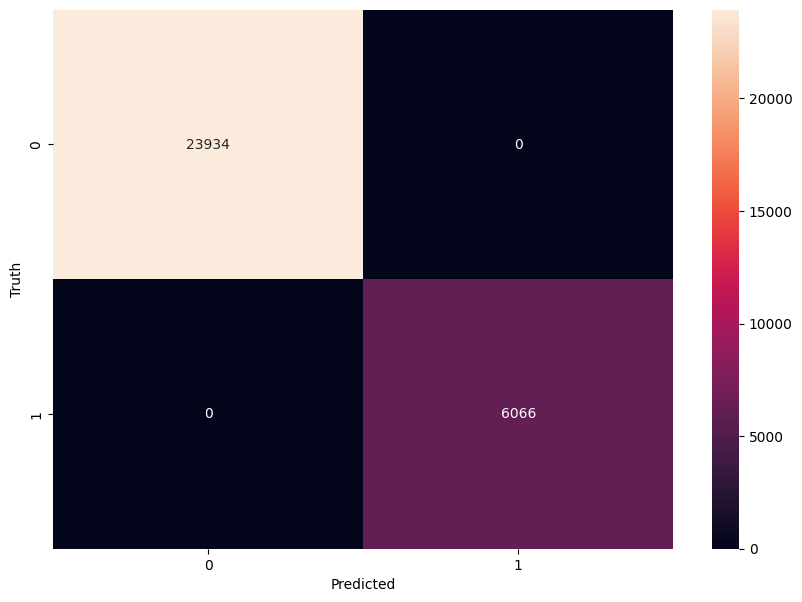

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprMID.csv')
meth_data = pd.read_csv('methylMID.csv')
assig_data = pd.read_csv('assignMID.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = meth_data
y = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
